In [479]:
import numpy as np
from numpy import typing as npt
from numpy import random as rnd
from pyclugen import clugen
import matplotlib.pyplot as plt
from collections.abc import Callable

In [480]:
# Infer output given an input array and the trained perceptron weights
def infer(inputs: npt.NDArray, weights: npt.NDArray, thresh: bool=True) -> float:
    if len(inputs) < len(weights):
        inputs = np.hstack((1, inputs))
    o = np.sum(inputs * weights)
    if thresh:
        if o > 0:
            o = 1
        elif o < 0:
            o = -1
    return o

# Infer outputs given an input matrix and the trained perceptron weights
def infer_all(data: npt.NDArray, weights: npt.NDArray, thresh: bool=True) -> npt.NDArray:
    return np.apply_along_axis(infer, 1, data[:, 0:-1], weights, thresh=thresh)

In [481]:
# Gradient descent perceptron training function
def gradient_descent(
    train_data: npt.NDArray,
    eta: float,
    iters: int = 1000,
    seed: int = 123,
    thresh: bool = True,
    hook: Callable[[npt.NDArray], None] = lambda w: None,
) -> npt.NDArray:
    n_weights = train_data.shape[1]
    train_data = np.hstack((np.ones((train_data.shape[0], 1)), train_data))
    rng = rnd.default_rng(seed)
    w = rng.uniform(-1, 1, n_weights)
    for _ in range(iters):
        dw = np.zeros(n_weights)
        for i in range(train_data.shape[0]):
            o = infer(train_data[i, 0:-1], w, thresh=thresh)
            for iw in range(n_weights):
                dw[iw] += eta * (train_data[i, -1] - o) * train_data[i, iw]
        for iw in range(n_weights):
            w[iw] += dw[iw]
        hook(w)
    return w

In [482]:
# Stochastic gradient descent perceptron training function
def stochastic_gradient_descent(
    train_data: npt.NDArray,
    eta: float,
    iters: int = 1000,
    seed: int = 123,
    thresh: bool = True,
    hook: Callable[[npt.NDArray], None] = lambda w: None,
) -> npt.NDArray:
    n_weights = train_data.shape[1]
    train_data = np.hstack((np.ones((train_data.shape[0], 1)), train_data))
    rng = rnd.default_rng(seed)
    w = rng.uniform(-1, 1, n_weights)
    for _ in range(iters):
        for i in range(train_data.shape[0]):
            o = infer(train_data[i, 0:-1], w, thresh=thresh)
            for iw in range(n_weights):
                w[iw] += eta * (train_data[i, -1] - o) * train_data[i, iw]
        hook(w)
    return w

In [483]:
# Determine fitness (0-1)
def fitness(classes1, classes2):
    return sum(classes1 == classes2) / len(classes1)

In [484]:
# Use this for keeping track of fitness evolution during training
class FitnessRegister:
    def __init__(self, train_data: npt.NDArray, iters: int):
        self.train_data = train_data
        self.i = 0
        self.fitnesses = np.zeros(iters)

    def hook(self, weights: npt.NDArray):
        new_clusters = infer_all(self.train_data, weights)
        self.fitnesses[self.i] = (
            sum(new_clusters == self.train_data[:, -1]) / self.train_data.shape[0]
        )
        self.i += 1

In [485]:
# Helper plot code
def plot_clusters(points: npt.NDArray, clusters: npt.NDArray, title: str = ""):
    fig, ax = plt.subplots()
    ax.scatter(points[:, 0], points[:, 1], c=clusters)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    if len(title) > 0:
        fig.suptitle(title)


def plot_training(iters: int, fitnesses: dict[str, npt.NDArray], title: str = ""):
    fig, ax = plt.subplots()
    for label, fits in fitnesses.items():
        ax.plot(range(0, iters), fits, label=label)
    ax.set_xlabel("Iterations")
    ax.set_ylabel("Fitness")
    ax.legend(title="Threshold?")
    if len(title) > 0:
        fig.suptitle(title)

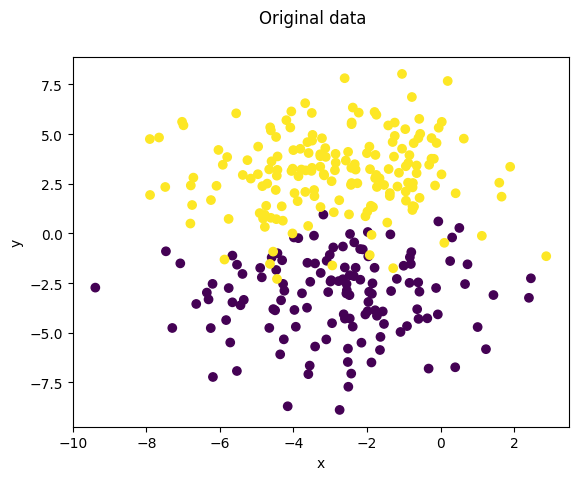

In [486]:
# Create some data with pyclugen
seed = 123

clust = clugen(
    2,
    2,
    300,
    [1, 1],
    np.pi / 4,
    [5, 5],
    0.1,
    0,
    2,
    point_dist_fn="n",
    rng=rnd.default_rng(seed),
)
clust.clusters[clust.clusters == 0] = -1

plot_clusters(clust.points, clust.clusters, "Original data")

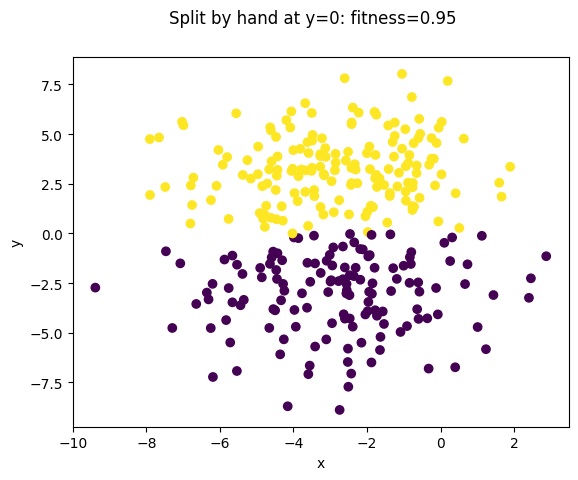

In [487]:
# Split by hand at y=0
new_clusters = np.zeros(len(clust.clusters))

for i in range(len(clust.clusters)):
    if clust.points[i, 1] < 0:
        new_clusters[i] = -1
    else:
        new_clusters[i] = 1

fitn = fitness(new_clusters, clust.clusters)

plot_clusters(clust.points, new_clusters, f"Split by hand at y=0: fitness={fitn}")


In [488]:
# Prepare data for training
train_data = np.hstack((clust.points, clust.clusters.reshape((-1, 1))))

Fitness when threshold is ON : 0.9366666666666666
Fitness when threshold is OFF: 0.94


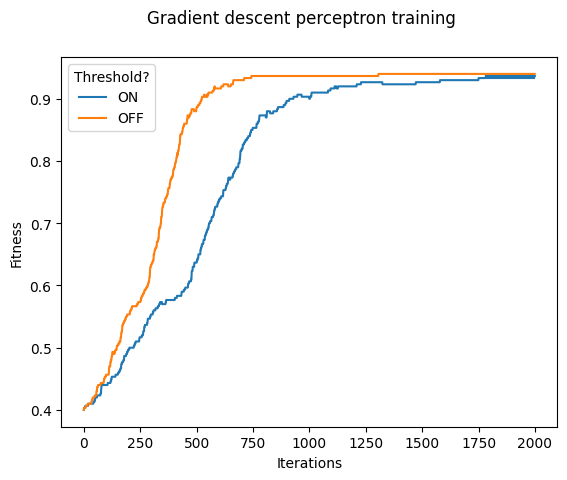

In [489]:
# Gradient descent training
learning_rate = 0.0000015
iters = 2000

fit_tracker_tt = FitnessRegister(train_data, iters)
fit_tracker_tf = FitnessRegister(train_data, iters)

w_tt = gradient_descent(
    train_data, learning_rate, iters, thresh=True, hook=fit_tracker_tt.hook
)
w_tf = gradient_descent(
    train_data, learning_rate, iters, thresh=False, hook=fit_tracker_tf.hook
)

new_clusters_tt = infer_all(train_data, w_tt)
new_clusters_tf = infer_all(train_data, w_tf)

print(f"Fitness when threshold is ON : {fitness(new_clusters_tt, clust.clusters)}")
print(f"Fitness when threshold is OFF: {fitness(new_clusters_tf, clust.clusters)}")

plot_training(
    iters,
    {"ON": fit_tracker_tt.fitnesses, "OFF": fit_tracker_tf.fitnesses},
    "Gradient descent perceptron training",
)

Fitness when threshold is ON : 0.9333333333333333
Fitness when threshold is OFF: 0.94


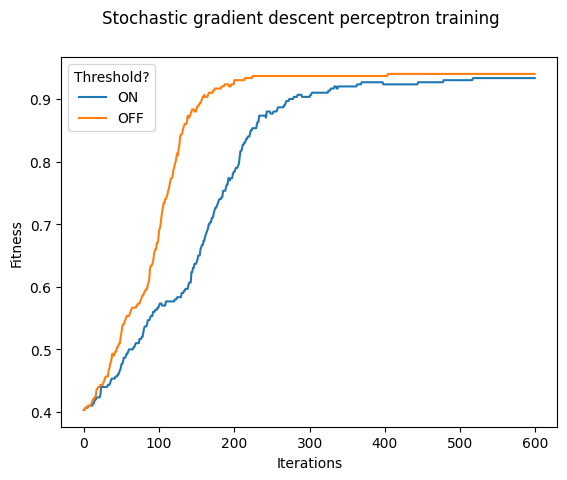

In [490]:
# Stochastic gradient descent training
learning_rate = 0.000005
iters = 600

fit_tracker_tt = FitnessRegister(train_data, iters)
fit_tracker_tf = FitnessRegister(train_data, iters)

w_tt = stochastic_gradient_descent(
    train_data, learning_rate, iters, thresh=True, hook=fit_tracker_tt.hook
)
w_tf = stochastic_gradient_descent(
    train_data, learning_rate, iters, thresh=False, hook=fit_tracker_tf.hook
)

new_clusters_tt = infer_all(train_data, w_tt)
new_clusters_tf = infer_all(train_data, w_tf)

print(f"Fitness when threshold is ON : {fitness(new_clusters_tt, clust.clusters)}")
print(f"Fitness when threshold is OFF: {fitness(new_clusters_tf, clust.clusters)}")

plot_training(
    iters,
    {"ON": fit_tracker_tt.fitnesses, "OFF": fit_tracker_tf.fitnesses},
    "Stochastic gradient descent perceptron training",
)